In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

2022-10-01 10:19:50.248534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 10:19:50.481354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 10:19:50.481391: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-01 10:19:50.534813: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-01 10:19:51.616244: W tensorflow/stream_executor/platform/de

load datasets

In [2]:
df = pd.read_csv('cleaned_train.csv')

In [3]:
validate = pd.read_csv('validate.csv')

In [4]:
scaler = MinMaxScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

AutoEncoder Neural Network Architecture

In [5]:
class SDD(tf.keras.models.Model):
    def __init__(self):
        super(SDD, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(15, activation='relu'),
            tf.keras.layers.Dense(10, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(15, activation='relu'),
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(37, activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def pred(self, data, threshold):
        if data.shape[0] == 37:
            data = data.reshape(1, 37)
        reconstructions = self.call(data)
        loss = tf.keras.losses.mse(reconstructions, data)
        print(loss)
        prediction = tf.math.greater(loss, threshold).numpy()
        for i in range(len(prediction)):
            if prediction[i] == True:
                prediction[i] = False
            else:
                prediction[i] = True
        return prediction

In [6]:
model = SDD()

2022-10-01 10:19:53.441847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 10:19:53.442997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 10:19:53.443238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-01 10:19:53.443447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-01 10:19:53.443651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [7]:
model.compile(optimizer='adam', loss='mse')

In [8]:
history = model.fit(scaled_data, scaled_data, epochs=250, batch_size=100, shuffle=True)

Epoch 1/250
27/27 [==============================] - 1s 3ms/step - loss: 0.0942
Epoch 2/250
27/27 [==============================] - 0s 2ms/step - loss: 0.0601
Epoch 3/250
27/27 [==============================] - 0s 3ms/step - loss: 0.0332
Epoch 4/250
27/27 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 5/250
27/27 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 6/250
27/27 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 7/250
27/27 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 8/250
27/27 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 9/250
27/27 [==============================] - 0s 4ms/step - loss: 0.0206
Epoch 10/250
27/27 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 11/250
27/27 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 12/250
27/27 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 13/250
27/27 [=================

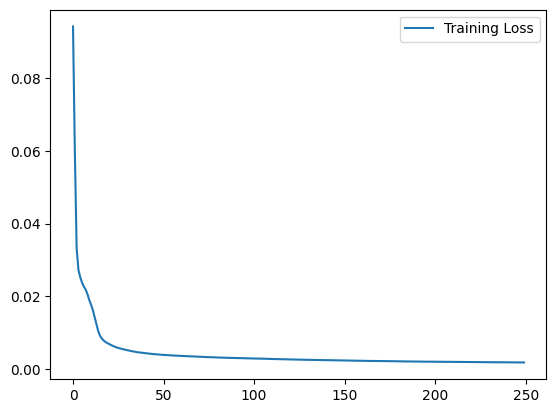

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [10]:
danger_example = scaled_data[514]

84/84 [==============================] - 0s 2ms/step


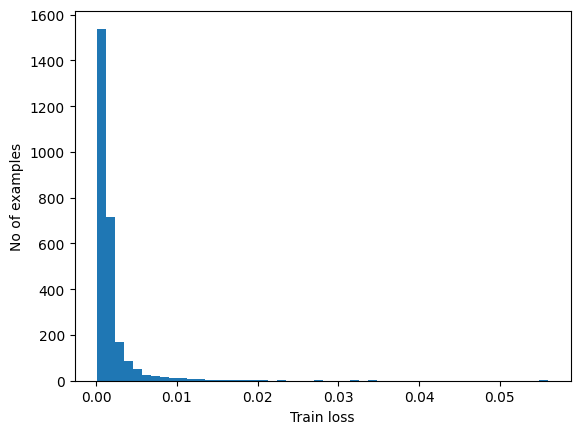

In [11]:
reconstructions = model.predict(scaled_data)
train_loss = tf.keras.losses.mse(reconstructions, scaled_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [12]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.004401929416980673


In [13]:
def plot_reconstruction(test_example):
    encoded_data = model.encoder(test_example.reshape(1, 37)).numpy()
    decoded_data = model.decoder(encoded_data).numpy()

    plt.plot(test_example, 'b')
    plt.plot(decoded_data[0], 'r')
    plt.fill_between(np.arange(37), decoded_data[0], test_example, color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [14]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

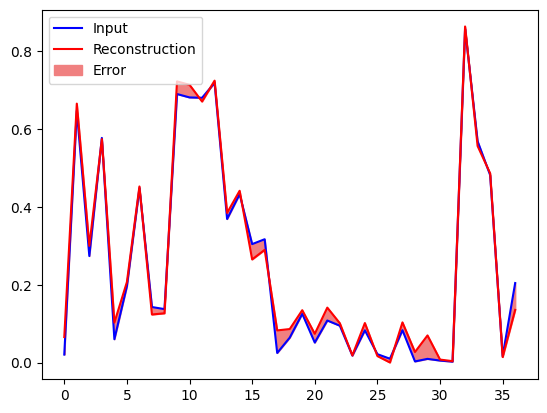

In [15]:
plot_reconstruction(danger_example)

In [16]:
normal_data = pd.read_csv("cleaned_norm_test.csv")
scaled_normal_data = scaler.transform(normal_data)

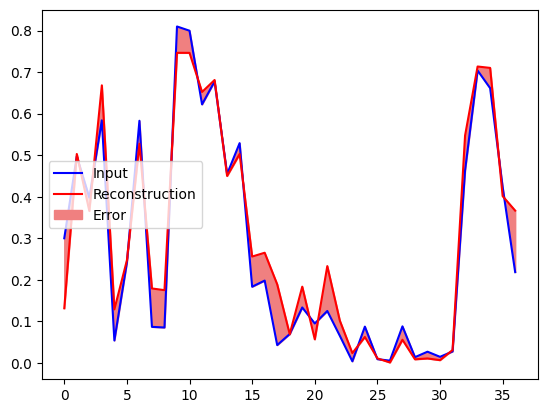

In [29]:
plot_reconstruction(scaled_normal_data[0])

In [18]:
X_normal = scaled_normal_data
Y_normal = np.full(X_normal.shape[0], 0)

In [19]:
X_test = validate.drop(["target"], axis=1)
X_test = scaler.transform(X_test)
Y_test = validate["target"]
Y_test = Y_test.astype(bool)

In [20]:
merged_df = pd.read_csv("merge.csv")
X = merged_df.drop(["target"], axis=1)
X = scaler.transform(X)
Y = merged_df["target"]
Y = Y.astype(bool)

In [24]:

preds = model.pred(X, threshold)
print_stats(preds, Y)

tf.Tensor([0.03442686 0.0104593  0.01135737 ... 0.00521225 0.00552812 0.00623917], shape=(4816,), dtype=float64)
Accuracy = 0.8806063122923588
Precision = 0.8661825726141079
Recall = 0.9301893798737467


[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

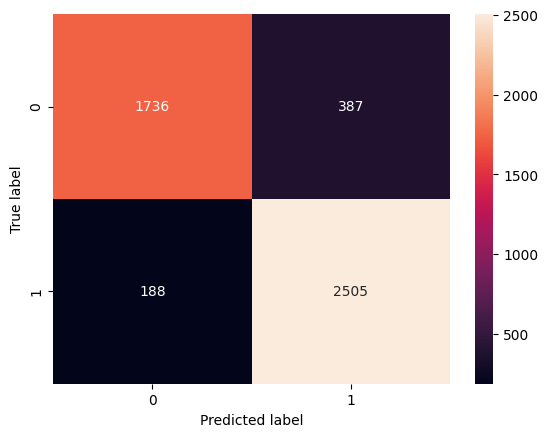

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, preds)
cm_plot = sns.heatmap(cm, annot=True, fmt='d') 
cm_plot.set(xlabel='Predicted label', ylabel='True label')